In [1]:
import numpy as np
import tensorflow as tf

# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 

import ipysh
import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

# Load the TensorBoard notebook extension
%load_ext tensorboard

%aimport models.AEFIT5
%aimport models.base
%aimport Dataset_QSH

Hunch models imported
reload set for module  Hunch_utils
reload set for module  Dummy_g1data
reload set for module  Hunch_lsplot
reload set for module  Hunch_tSNEplot


In [2]:
qsh = Dataset_QSH.Dataset_QSH()
import os
file = ipysh.abs_builddir+'/te_db_r15u_shuffle.npy'
if os.path.isfile(file):
    qsh.load(file)
    
qsh.clean_up_poorcurves(5)
qsh.dim = 15
qsh.set_null(np.nan)
qsh.set_normal_positive()
# qsh.unbias_mean(0.5, 'te')
# qsh.set_normal_positive()

# print("QSH rebalanced 15 points size: ", len(qsh))

# qsh.set_null(np.nan)
# qsh.clip_values(0.1,0.6)
# qsh.set_normal_positive()

In [375]:
vae = models.AEFIT5.AEFIT5(latent_dim=3, feature_dim=30, dprate=0., scale=1, beta=0., geometry=[20,20,10,10])

def encode(self, X, training=None):
    def col_to_zero(tensor, col_to_zero=[]):
        # col_to_zero = [0, 2] # <-- column numbers you want to be zeroed out
        tnsr_shape = tf.shape(tensor)
        mask = [tf.one_hot(col_num*tf.ones((tnsr_shape[0], ), dtype=tf.int32), tnsr_shape[-1])
                for col_num in col_to_zero]
        mask = tf.reduce_sum(mask, axis=0)
        mask = tf.cast(tf.logical_not(tf.cast(mask, tf.bool)), tf.float32)
        return tensor * mask
    
    mean, logvar = tf.split(self.inference_net(X, training=training), num_or_size_splits=2, axis=1)
    mean = col_to_zero(mean, [0])
    one = tf.ones(tf.shape(logvar))
    logvar = col_to_zero(logvar, [0]) + one - col_to_zero(one, [0])
    return mean, logvar

models.AEFIT5.AEFIT5.encode = encode    

# def col_to_zero(tensor, col_to_zero=[]):
#     # col_to_zero = [0, 2] # <-- column numbers you want to be zeroed out
#     tnsr_shape = tf.shape(tensor)
#     mask = [tf.one_hot(col_num*tf.ones((tnsr_shape[0], ), dtype=tf.int32), tnsr_shape[-1])
#             for col_num in col_to_zero]
#     mask = tf.reduce_sum(mask, axis=0)
#     mask = tf.cast(tf.logical_not(tf.cast(mask, tf.bool)), tf.float32)
#     return tensor * mask

# tensor = tf.constant([[4, 5, 6],
#                       [7, 8, 9],
#                       [4, 125, 6],
#                       [72, 81, 91]], dtype=tf.float32)


# one = tf.ones(tf.shape(tensor)) 
# col_to_zero(tensor,[0]) + one - col_to_zero(one, [0])




AEFIT5 ready:


In [360]:
ds = qsh.ds_array.map(lambda x,y: (x,x))
# x,_ = [x for x in ds.batch(10).take(1)][0]
# vae.encode(x)

In [374]:
class RecordRelevanceDrop(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):        
        R = self.model.generative_net.layers[0].weights[0].numpy()
        for i,r in enumerate(R): self.R_epoch[i].append(r)
        return super().on_epoch_end(epoch, logs=logs)
    
    def on_train_batch_end(self, batch, logs=None):        
        R = self.model.generative_net.layers[0].weights[0].numpy()
        for i,r in enumerate(R): self.R[i].append(r)
        return super().on_train_batch_end(batch, logs=logs)
        
    def set_model(self, model):
        self.model = model        
        self.R = [[] for _ in range(model.latent_dim)]
        self.R_epoch = [[] for _ in range(model.latent_dim)]
        for i in range(model.latent_dim):
            self.R[i].append(1.)
            self.R_epoch[i].append(1.)
        

In [376]:
vae.beta.assign( 0 )
h = models.base.RecordMetrics()
hR = RecordRelevanceDrop()
fit = lambda: vae.fit(ds.skip(5000).batch(100, drop_remainder=True), validation_data=ds.take(5000).batch(100), epochs=45, shuffle=False, callbacks=[h, hR])
models.base.fn_thread(vae, fit).control_panel()

Epoch 1/45
     68/Unknown - 3s 46ms/step - loss: 0.0160 - mse: 0.0160 - akl: 2.5040 - mkl: 1.8453 - b: 0.0000e+00

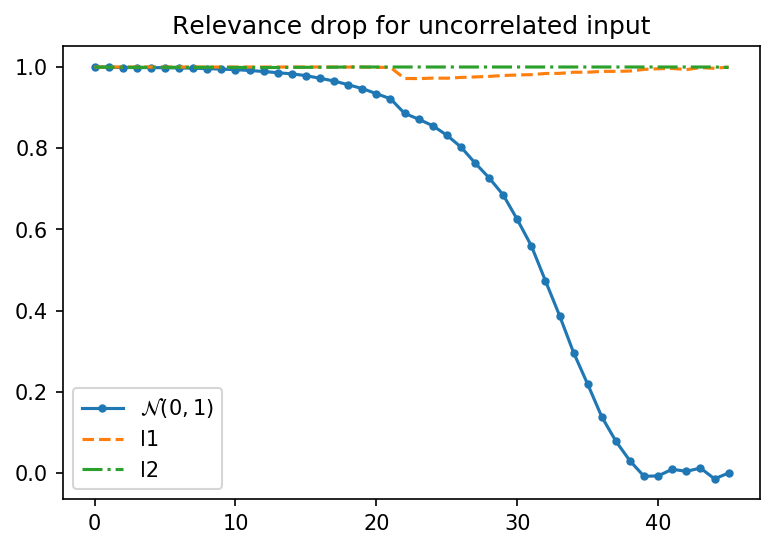

In [396]:
fig = plt.figure('Relevance')
fig.set_dpi(150)
ax = plt.gca()
ax.set_title('Relevance drop for uncorrelated input')
plt.plot(hR.R_epoch[0], '.-',label='$\mathcal{N}(0,1)$')
plt.plot(hR.R_epoch[1], '--',label='l1')
plt.plot(hR.R_epoch[2], '-.',label='l2')
plt.legend()

<BarContainer object of 30 artists>

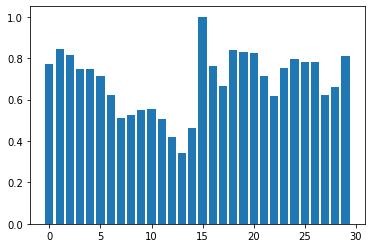

In [413]:
R = vae.generative_net.layers[0].weights
R = R[0].numpy()

Ri = vae.inference_net.layers[1].weights[0].numpy()
plt.bar(range(len(Ri)),Ri)


# TRY TO ADD DROPOUT
Please note that Dropout is NOT placed after the R layer but after all Dense

As a first attempt we try a high dropout rate = 0.5 ... half of dense connections are dropped during training.

In [414]:
vae_dp = models.AEFIT5.AEFIT5(latent_dim=3, feature_dim=30, dprate=0.5, scale=1, beta=0., geometry=[20,20,10,10])

AEFIT5 ready:


In [415]:
h_dp = models.base.RecordMetrics()
hR_dp = RecordRelevanceDrop()
fit_dp = lambda: vae_dp.fit(ds.skip(5000).batch(100, drop_remainder=True), validation_data=ds.take(5000).batch(100), epochs=45, shuffle=False, callbacks=[h_dp, hR_dp])
models.base.fn_thread(vae_dp, fit_dp).control_panel()

Epoch 1/45
425/425 [==============================] - 15s 34ms/step - loss: 0.0086 - mse: 0.0086 - akl: 3.4793 - mkl: 3.4391 - b: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_akl: 0.0000e+00 - val_mkl: 0.0000e+00 - val_b: 0.0000e+00
Epoch 2/45
47/50 [===========================>..] - ETA: 0s - loss: 0.0026 - mse: 0.0026 - akl: 5.2462 - mkl: 4.8750 - b: 0.0000e+00

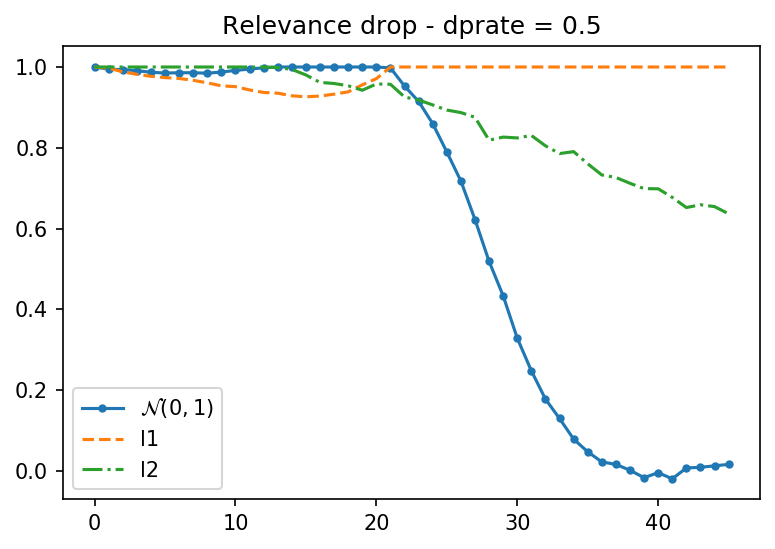

In [463]:
fig = plt.figure('Relevance')
fig.set_dpi(150)
ax = plt.gca()
ax.set_title('Relevance drop - dprate = 0.5')
plt.plot(hR_dp.R_epoch[0], '.-',label='$\mathcal{N}(0,1)$')
plt.plot(hR_dp.R_epoch[1], '--',label='l1')
plt.plot(hR_dp.R_epoch[2], '-.',label='l2')
plt.legend()

The droprate 0.5 is quite degrading the confidence.

See it with a reduced rate = 0.2

In [464]:
vae_dp = models.AEFIT5.AEFIT5(latent_dim=3, feature_dim=30, dprate=0.2, scale=1, beta=0., geometry=[20,20,10,10])

AEFIT5 ready:


In [465]:
h_dp = models.base.RecordMetrics()
hR_dp = RecordRelevanceDrop()
fit_dp = lambda: vae_dp.fit(ds.skip(5000).batch(100, drop_remainder=True), validation_data=ds.take(5000).batch(100), epochs=45, shuffle=False, callbacks=[h_dp, hR_dp])
models.base.fn_thread(vae_dp, fit_dp).control_panel()

Epoch 1/45
425/425 [==============================] - 14s 32ms/step - loss: 0.0046 - mse: 0.0046 - akl: 4.7660 - mkl: 4.5239 - b: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_akl: 0.0000e+00 - val_mkl: 0.0000e+00 - val_b: 0.0000e+00
Epoch 2/45
425/425 [==============================] - 12s 28ms/step - loss: 9.5637e-04 - mse: 9.3777e-04 - akl: 7.4896 - mkl: 7.2239 - b: 0.0000e+00 - val_loss: 4.3548e-04 - val_mse: 4.3548e-04 - val_akl: 8.0750 - val_mkl: 7.8991 - val_b: 0.0000e+00
Epoch 3/45
425/425 [==============================] - 12s 27ms/step - loss: 7.3763e-04 - mse: 7.3258e-04 - akl: 9.4501 - mkl: 9.0852 - b: 0.0000e+00 - val_loss: 4.3098e-04 - val_mse: 4.3098e-04 - val_akl: 9.5795 - val_mkl: 9.4209 - val_b: 0.0000e+00
Epoch 4/45
425/425 [==============================] - 12s 27ms/step - loss: 6.6869e-04 - mse: 6.6684e-04 - akl: 10.6946 - mkl: 10.3849 - b: 0.0000e+00 - val_loss: 4.2277e-04 - val_mse: 4.2277e-04 - val_akl: 10.7862 - val_mkl: 10.6167 - val_b: 0.0000e

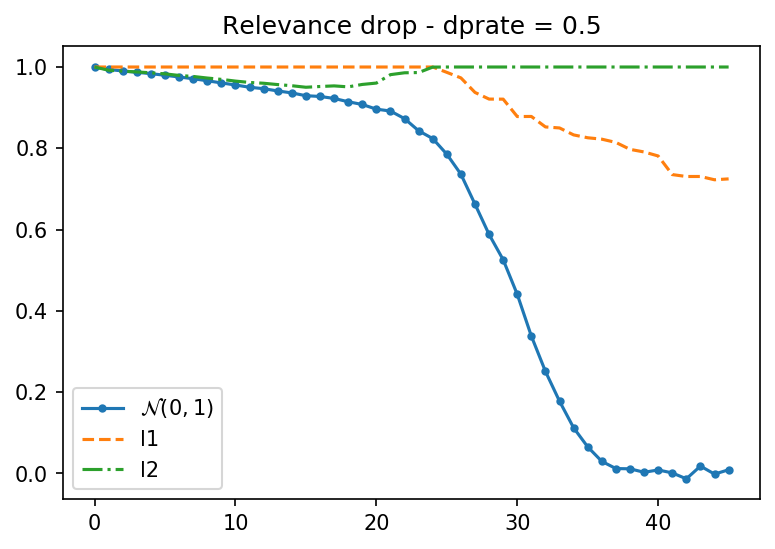

In [475]:
fig = plt.figure('Relevance')
fig.set_dpi(150)
ax = plt.gca()
ax.set_title('Relevance drop - dprate = 0.5')
plt.plot(hR_dp.R_epoch[0], '.-',label='$\mathcal{N}(0,1)$')
plt.plot(hR_dp.R_epoch[1], '--',label='l1')
plt.plot(hR_dp.R_epoch[2], '-.',label='l2')
plt.legend()